# Physics-informed neural networks for the solution of 1 dimensional equations

In [1]:
# Set the correct search path for importing packages
import sys
sys.path.insert(1, '../PINNLearning')
# Surpress unnecessary output from tensorflow package
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import necessary functions/ packages
from training import learning_rate_schedule, train, simp_loss
from data import gen_data, set_boundaries, simp_sol, simp_sim
from models import create_model
import matplotlib.pyplot as plt
import keras

We first need to set some global values and settings:

In [2]:
# Plot settings
plt.close('all')
plt.rcParams['font.family'] = 'Ubuntu Nerd Font'
plt.rcParams['font.size'] = 10

# Dimensions of the simulation space
lower_bound = 0.0
upper_bound = 1.0

## Initial Testing with boundary conditions

We try to solve the heat equation:

$\dfrac{\partial u(x, t)}{\partial t} = \alpha \cdot \Delta u(x, t)$

For this we intially set some simplifications:
* The diffusion factor $\alpha$ is set to 1
* The function is not dependend on the time: $u(x, t) = u(x)$
* The function is only 1 dimensional: $\Delta u(x, t) = \frac{d^2 u(x, t)}{d^2x}$


With these simplifications the upper equation results to:

$u(x) = \dfrac{d^2}{dx^2} u(x)$

With the dirichlet boundary conditions set to:

$u(0) = 1$ and $u(1) = 0$

It is easily possible adjust these and to change them to Neumann boundary conditions, by adjusting the loss function used for trainging the PINN.

For comparative purposes, the here described boundaries result in the following analytical solution for this equation:

$u(x) = \dfrac{e^{-x} (e^2-e^{2x})}{e^2-1}$

As the model will be created using Tensorflow (Tf), all data must be in the format of a Tf tensor.
For this, the boundary conditions first need to be converted to a tensors.

Because the differential equation fully describes our problem and (enough) boundary conditions are given, we can adopt an unsupervied learning regime (data points only entail an x value, no correct y value).
In line with this, the training data can just be (by choice also randomly) generated accross the problem space from above but must be ultimately converted to a Tf tensor.
The dimenions of this tensor are important as Tf automatically generates the input layer of the neural network from this. Tf uses the _„row-major“_ storage format, thereby every **row** is a seperate data point and every **column** is a seperte input feature.


When creating the model, a lot of hyperparameters, such as the learning rate or the dimensions of the network itself, can be adjusted. 
For simple problems like this one, this is not necessary. However, for larger and more complex problems it can be vital to boost the performance. An examplery implementation of a such an Hyperparameter Optimizaion (HPO) Algorithm together with an Neural Architectur Search (NAS) Algorithm can be found in the `HPO & NAS` notebook.
For this initiall problem we do without it.


Furthermore, for all implementations here it first checks if the model is already trained and entailed in the subdirectory `data`. If this is the case, the training will be suspendend (but can be manually forced). Otherwise the model will be automatically trained and a loss-time development graph will be printed.

In [3]:
# Set the boundary conditions
x_bc, y_bc = set_boundaries([[0.0], [1.0]], [[1.0], [0.0]])

# Create the training data
x_train = gen_data(lower_bound, upper_bound, 100)

# Create the model with fixed sizes
model = create_model(3, 50)

# Create a learning rate schedule
# The purpose of which is to make learning more robust and increase speed
lr_schedule = learning_rate_schedule(1e-3, 1000, 0.9)

# Train the model if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model = keras.models.load_model('../data/simp_initial.keras')
except Exception as e:
    error_time = train(model, x_train, x_bc, y_bc, lr_schedule, threshold=1e-8)
    model.save('../data/simp_initial.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Development of the Loss over the Epochs')
    plt.show()

When the model is finished training, it needs to be tested against a more general case (called validation).
For this purpose, more data points must be gernerated and evaluated accross the problem space – the points that the model was trained on **CAN NOT** be part of this set!

As can probably be seen here the loss over this validation data set will often be greater than the final training loss. As long as the difference is not orders of magnitudes, this still indicates a good performing model.

For further testing of the resulting model, the analytical solution is also inferenced accorss the validation data set. A graphical comparison is presented below.

The loss over the validation data is: 0.00020972054335288703


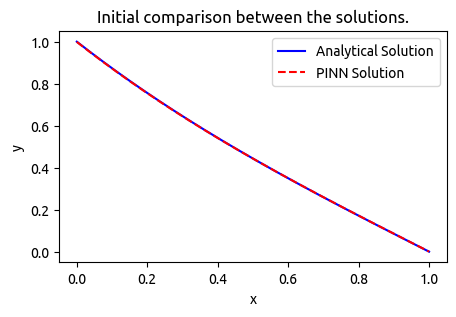

In [4]:
x_test = gen_data(lower_bound, upper_bound, 1000)

# Calculate the loss over the test data
val_loss = simp_loss(model, x_test, x_bc, y_bc)
print(f"The loss over the validation data is: {val_loss}")

y_pred = model(x_test).numpy()
y_true = simp_sol(x_test)

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial comparison between the solutions.')
plt.show()

## Initial Equation without boundary conditions

In some situations (typically more practical applications), the differential equations fully describing the problem can not be found or not all necessary boundary conditions are given.
However, as long as governing equations can be formulated this situation can still be solved.

For this purpose, the loss function needs to be adjusted to incorporate **real world mesurement data**. 

This however, also introduces the problem of noice in the traing data and must be done carfully.

In the simplified problem from above, this situation is imitated by removing the boundary conditions.

The points of the training and the validation data are sampled once from the analytic solution (no noice in the data – ideal measuremnts) and once from an simulation of the function (noicy measurements).



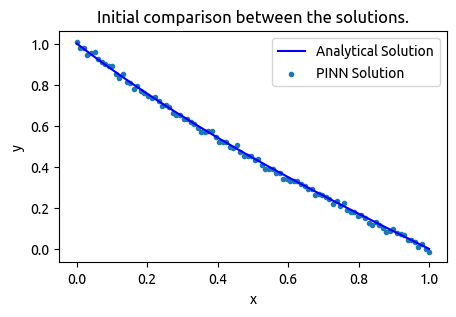

In [7]:
x_test = gen_data(lower_bound, upper_bound, 100)


y_pred = simp_sim(x_test, y_bc)[1]
y_true = simp_sol(x_test)

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b', label="Analytical Solution")
plt.scatter(x_test, y_pred, label='PINN Solution', marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial comparison between the solutions.')
plt.show()